# Lab Assignment Four: Extending Logistic Regression 

$$ Team Member Names: Rongxiao Huang, Zeen Liu, Hua Zong $$

______
<a id="top"></a>
## Contents
* <a href="#BD">1. Business Understanding and Data Preparation</a>
* <a href="#EV">2. Evaluation</a>
* <a href="#MO">3. Modeling</a>
* <a href="#EX">4. </a>
* <a href="#DP">5. Deployment</a>
* <a href="#RE">Reference</a>

___
<a id="BD"></a>
<a href="#top">Back to Top</a>
## 1. Business Understanding and Data Preparation

### 1.1 Business Understanding

**Dataset:** The Chile data frame has 2700 rows and 8 columns. The data are from a national survey conducted in April and May of 1988 by FLACSO/Chile.                    https://vincentarelbundock.github.io/Rdatasets/doc/car/Chile.html


According to the Wikipedia, the 1988 Chilean national plebiscite was a national referendum held on 5 October 1988 to determine whether Chile's President, Augusto Pinochet, should extend his rule for another eight years. And the candidate was to be ratified by registered voters in a national plebiscite. This data set is a part of the natioanl survey on the registered voters in 1988.

We found that there are missing values in vote status. Therefore, we would like to predict what the voting decisions from those people are by using our neutral network models. And then we compared the results with and without imputaion of voting.

Though the voting back to the late 1980s, the model would still help some Chlian Political Science researchers and scholars in the related field. As the Wikipiedia states, the dictatorship ending is attributed to the pressure from business and unease with Pinochet's rule. The model would help us to see how was the social economic status behind the voters who voted "Yes", "No", "Undecided", or even "Abstain" in the Aprial and May of 1988, two quarters before the final voting. Especially in the undecided class, which were over 20% of the given sample, researchers would like to know how this group would act in the final voting and how the last-five-month campaign affected the undecided group in the registered voters.

Besides, The political parties endorsed the votings would be interested in the models as well. Through the model, the political parties related in this voting would also see social economic status from the surveyed voters. Therefore, the parties could have know what groups of people they should work on to earn more votes for their own camps. 



### 1.2. Data Understanding and Pre-processing

** The class variable: vote (voting status) ** -- A factor with levels: `A`, will abstain; `N`, will vote no (against Pinochet); `U`, undecided; `Y`, will vote yes (for Pinochet).


#### 1.2.1 Data Pre-processing

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# 1. load the chile-voting dataset
df = pd.read_csv('C:/Users/zeen/Desktop/lason/lab 4/Chile.csv')

# 2. delete the fist column, which refers to index
del df['Unnamed: 0']

# 3. convert education level to numrical indicator
#    It was a factor with levels (note: out of order in the original dataset): 
#    P, Primary; PS, Post-secondary; S, Secondary. 
df.education.replace(to_replace = ['P', 'S', 'PS'],
                 value = range(3), inplace = True)

# 4. convert sex to numrical indicator
#    A factor with levels: F, female; M, male. 
df.sex.replace(to_replace = ['F', 'M'],
                 value = range(2), inplace = True)

df['IsMale'] = df.sex # replace the current Sex atribute with something slightly more intuitive and readable
del df['sex']

There are some missing data in the columns: `age, education, income, statusquo`, and `vote.`

We decided to delete the rows with missing value in `vote`, because it is the class variable we would like to predict. However, we stored these instances into another object, of which the instance would be predicted as a certain class by implementing our models.

We also agreed to delete the rows with missing value in the column of `education`, because we planned to impute the missing values in `income` and `statusquo` by using groups' medians according to `region, population, sex` and `education`.

In [2]:
# 5. impute some missing values, grouped by their 
#    region, population, sex and education
df_grouped = df.groupby(by=['region','population','IsMale','education'])
#    now use this grouping to fill the data set in each group, 
#    then transform back fill in the numeric values
df_imputed = df_grouped.transform(lambda grp: grp.fillna(grp.median())) 
#    fillin the grouped variables and vote from original data frame
df_imputed[['region','population','IsMale','education','vote']] = df[['region','population','IsMale','education','vote']]

# 6. scale 'population','age','income'
norm_features = ['population','age','income']
df_imputed[norm_features] = (df_imputed[norm_features]-df_imputed[norm_features].mean()) / df_imputed[norm_features].std()

# 7. rearrange the columns
df_imputed = df_imputed[['region','population','IsMale','education','age','income','statusquo','vote']]

We should then check whether duplicate data exists.

Through the duplicates check, it shows there are 9 duplicated observations in the dataset. We decided to keep these in the dataset because we don't have obivious evidence to prove it's true duplicates since no ID information showed in the dataset.

In [3]:
# 8. find the duplicate instances
idx = df_imputed.duplicated()
df_imputed[idx] # list the instances which are not the first-show

,region,population,IsMale,education,age,income,statusquo,vote
1996,SA,0.956748,0,0.0,0.301385,-0.671164,-1.29617,N
2172,SA,0.956748,0,1.0,-0.986285,-0.671164,-1.29617,N
2246,SA,0.956748,0,2.0,-0.986285,0.035127,-1.29617,N
2269,SA,0.956748,0,1.0,-0.782969,-0.478539,-1.29617,N
2272,SA,0.956748,0,2.0,-1.054057,0.035127,-1.29617,N
2296,SA,0.956748,0,1.0,-1.257374,0.035127,-1.29617,N
2401,SA,0.956748,0,1.0,-1.257374,0.035127,-1.25795,N
2468,SA,0.956748,0,2.0,-0.850741,2.346623,-1.21834,N
2495,SA,0.956748,1,1.0,-1.054057,-0.478539,-1.29617,N


In [4]:
# 9. convert vote to numerical indicator
df_imputed.vote.replace(to_replace = ['N', 'Y', 'U','A'],
                 value = range(4), inplace = True)

# 10. store the rows with missing value in vote
df_vote_na = df_imputed[pd.isnull(df_imputed.vote).values]
del df_vote_na['vote']
df_vote_na.dropna(inplace=True)
df_imputed.dropna(inplace=True)
df_imputed.vote = [int(x) for x in df_imputed.vote] # restrict to integer
df_imputed.education = [int(x) for x in df_imputed.education] # restrict to integer
df_vote_na.education = [int(x) for x in df_vote_na.education] # restrict to integer

# 11. perform one-hot encoding of the categorical data "region"
tmp_df = pd.get_dummies(df_imputed.region,prefix='region')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe
del df_imputed ['region'] # delete region column

# 12. summary table
df_imputed.info()
df_imputed.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2522 entries, 0 to 2699
Data columns (total 12 columns):
population    2522 non-null float64
IsMale        2522 non-null int64
education     2522 non-null int64
age           2522 non-null float64
income        2522 non-null float64
statusquo     2522 non-null float64
vote          2522 non-null int64
region_C      2522 non-null float64
region_M      2522 non-null float64
region_N      2522 non-null float64
region_S      2522 non-null float64
region_SA     2522 non-null float64
dtypes: float64(9), int64(3)
memory usage: 256.1 KB


,population,IsMale,education,age,income,statusquo,vote,region_C,region_M,region_N,region_S,region_SA
count,2522.000000,2522.000000,2522.000000,2522.000000,2522.000000,2522.000000,2522.000000,2522.000000,2522.000000,2522.000000,2522.000000,2522.000000
mean,-0.004372,0.483743,0.762887,-0.020143,0.004754,-0.003286,1.028549,0.224822,0.032117,0.123711,0.268834,0.350515
std,0.997701,0.499835,0.726941,0.998648,1.006587,1.003327,0.937970,0.417548,0.176347,0.329317,0.443442,0.477226
min,-1.452789,0.000000,0.000000,-1.392918,-0.799580,-1.803010,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.244860,0.000000,0.000000,-0.918513,-0.478539,-1.006940,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.222879,0.000000,1.000000,-0.173020,-0.478539,-0.073510,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.956748,1.000000,1.000000,0.708018,0.035127,0.972310,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,0.956748,1.000000,2.000000,2.131233,4.272869,2.048590,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000


** An important information: rate for each class:**

In [5]:
# calculate the rates of each class
print('The rate before being imputed by the model')
print('---------------------------')
print('The against(Pinochet) rate:',sum(df.vote == 'N')/len(df_imputed))
print('The support(Pinochet) rate:', sum(df.vote == 'Y')/len(df_imputed))
print('The undecided rate:',sum(df.vote == 'U')/len(df_imputed))
print('The abstain rate:', sum(df.vote == 'A')/len(df_imputed))

The rate before being imputed by the model
---------------------------
The against(Pinochet) rate: 0.352498017446
The support(Pinochet) rate: 0.344171292625
The undecided rate: 0.233148295004
The abstain rate: 0.0741475019826


#### 1.2.2 Final Dataset Description

In [6]:
# 15. create a data description table
data_des = pd.DataFrame()

data_des['Features'] = df_imputed.columns
data_des['Description'] = ["population size of respondent's community (in thousand)", 
                           "sex of respondent","education level of respondent",
                           "age of respondent","monthly income, in one thousand Pesos",
                           "scale of support for the status-quo",
                           "vote status","central region","metropolitan Santiago area",
                           "northern region","southern region","city of Santiago"]
data_des['Scales'] = ['ratio']+ ['nominal']+['ordinal']+['ratio']*3+['nominal']+['nominal']*5
data_des['Discrete\Continuous'] = ['continuous'] + ['discrete']*3 + \
                                  ['continuous']*2 + ['discrete']*6
data_des['Range'] = ['3.750 - 250'] + ['0: No; 1: Yes'] + ['0: primary; 1: secondary; 2: post-secondary'] + \
                    ['18 - 70'] + ['2.5 - 200'] + ['-1.80 - 2.05'] + \
                    ['0: vote no (against Pinochet); 1: vote yes (for Pinochet); 2: undecided; 3: abstain'] + \
                    ['0: No; 1: Yes']*5

data_des

,Features,Description,Scales,Discrete\Continuous,Range
0,population,population size of respondent's community (in ...,ratio,continuous,3.750 - 250
1,IsMale,sex of respondent,nominal,discrete,0: No; 1: Yes
2,education,education level of respondent,ordinal,discrete,0: primary; 1: secondary; 2: post-secondary
3,age,age of respondent,ratio,discrete,18 - 70
4,income,"monthly income, in one thousand Pesos",ratio,continuous,2.5 - 200
5,statusquo,scale of support for the status-quo,ratio,continuous,-1.80 - 2.05
6,vote,vote status,nominal,discrete,0: vote no (against Pinochet); 1: vote yes (fo...
7,region_C,central region,nominal,discrete,0: No; 1: Yes
8,region_M,metropolitan Santiago area,nominal,discrete,0: No; 1: Yes
9,region_N,northern region,nominal,discrete,0: No; 1: Yes


** Note: ** It would be better to incorporate the data pre-poccessing into the stages in Pipeline. However, here we scaled and imputed the data at the beginning. It might compromise our results without building the pipeline. But we will aviod the data snooping problem in post-processing part by implementing the cross validation technique.

___
<a id="EV"></a>
<a href="#top">Back to Top</a>
## 2. Evaluation 

### 2.1 Evaluation Metric

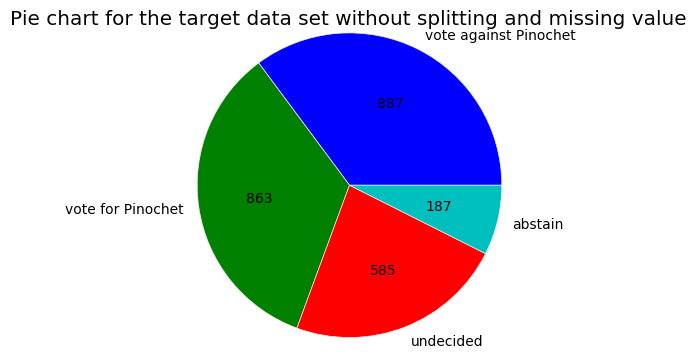

Number of instances in the binary classification problem: 2522


In [7]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# plot a pie chart of classes
labels = "vote against Pinochet", "vote for Pinochet", "undecided", "abstain"
vote = df_imputed['vote']
sizes = [sum(vote == 0), sum(vote == 1), sum(vote == 2), sum(vote == 3)]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct=lambda p: '{:.0f}'.format(p * len(vote) / 100))
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Pie chart for the target data set without splitting and missing value')
plt.show()

print('Number of instances in the binary classification problem:', len(vote))

Because the target's class sizes are extremely unbalanced, we should use other evaluation metric instead of accuracy, which evaluates the true negatives equally with the true positives. However, we care more about whether the algorithm correctly classfied a particular class, therefore the F1 score was chosen for our scorer, which is an average evaluation of the precision and the recall.

There are two methods by which you can get such average statistic of information retrieval and classification.
In Micro-average method, you sum up the individual true positives, false positives, and false negatives of the system for different sets and the apply them to get the statistics; In Macro-average method, you just take the average of the F1 score of the system on different sets. 

Suitability macro-average method, which weights all classes equally, can be used when you want to know how the system performs overall across the sets of data. On the other hand, micro-average method, which weights all instances equally, can be a useful measure when your dataset varies in size. Here we chosen micro-average method because we have different class sizes.

http://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin/16001 

** To sum up, we decided to use micro-average F1 score as our evaluation scorer. **

In [8]:
from sklearn.metrics import make_scorer,f1_score

### 2.2 Data Splitting

We created 10 pairs of train sets and test sets by stratifiedly splitting the imputed data (after shuffle) according to the classes in vote. We used the train set for model training, while the test set for evaluation. The evaluation result from each fold genearlly gives us an overall idea about the performace of each model when we conduct the model comparison.

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

# we want to predict the X and y data as follows:
if 'vote' in df_imputed:
    y = df_imputed['vote'].values # get the labels we want
    del df_imputed['vote'] # get rid of the class label
    X = df_imputed.values # store in matrix

# split our data into train and test sets 
# shuffle-split 10 times
cv_outerloop = StratifiedShuffleSplit(n_splits=10, test_size  = 0.3, random_state = 11)

___
<a id="MO"></a>
<a href="#top">Back to Top</a>
## 3. Modeling

### 3.1 Individual  TML Classifier

We created three two-layer-perceptron neural networks by setting different hyper-parameters in scikitlearn. And then we created a custom ensemble classifier that uses these three classifiers.

We setting the parameters to make sure the three MLP models are the weak learner. Therefore, we can expect the ensemble classifier to perform obviously better than the individual three weak classifiers.

In [10]:
from sklearn.neural_network import MLPClassifier

# define the hyper-parameters
params = dict(hidden_layer_sizes=(30, ), 
              solver='sgd', 
              batch_size= 'auto', # min of 200, num_samples
              learning_rate='constant', # adapt learning? only for sgd
              learning_rate_init=0.1, # only SGD
              power_t=0.0,    # only SGD with inverse scaling of learning rate
              shuffle=True, 
              random_state=1, 
              tol=0, # for stopping
              verbose=False, 
              warm_start=False, 
              nesterovs_momentum=False, # only SGD
              early_stopping=False, 
              validation_fraction=0.0, # only if early_stop is true
              beta_1=0.9, # adam decay rate of moment
              beta_2=0.999, # adam decay rate of moment
              epsilon=1e-08)

# 1. The first classifier
clf_1 = MLPClassifier(**params, 
                      activation='logistic', # type of non-linearity, every layer
                      alpha=30, # L2 penalty
                      max_iter=10, # stopping criteria
                      momentum=0.3) # only SGD

# 2. The first classifier
clf_2 = MLPClassifier(**params, activation='relu', alpha=1, max_iter=1, momentum=0)

# 3. The first classifier
clf_3 = MLPClassifier(**params, activation='logistic', alpha=20, max_iter=3, momentum=1)

### 3.2 Ensemble Classifier

We created the custom Ensemble Classifier with BaggingClassifier from scikit-learn. Therefore, we can use more than three individual classifiers into the created Ensemble Classifier. The bagging numbers and samples in each bagging is initially setted as 100 and 500 respectively.

Note that the bootstrap was setted as FALSE in the bagging. As we learned from the previous output, Class 3 and Class 4 only have very small portion. Therefore, if we use the bootstrap sampling in bagging each bagging might have huge portion of the first two classes and very rare portion of the Class 3 and 4. Though the Ensemble Classifier could improve the prediction performance, no prediction in the Class 3/4 would not match our original point of interest.

In [11]:
from sklearn.ensemble import BaggingClassifier

# create our custom ensemble classifier
class elf(object):
    def __init__(self, base_estimators, n_estimators=100, max_samples=500, bootstrap=False):
        self.base_estimators=base_estimators # list of base classifiers
        self.n_estimators=n_estimators # the number of base estimators in the ensemble (BaggingClassifier).
        self.max_samples=max_samples # the number of samples to draw from X to train each base estimator.
        self.bootstrap=bootstrap # whether samples are drawn with replacement.
    
    def fit(self, X, y):
        """ Learn from training data."""
        self.ests=[]            
        for base in self.base_estimators:
            
            clf_eb = BaggingClassifier(base_estimator=base, 
                           n_estimators=self.n_estimators, 
                           max_samples=self.max_samples,  
                           #oob_score=True,
                           bootstrap=self.bootstrap,
                           n_jobs=1, 
                           random_state=None)
            
            clf_eb.fit(X, y)           
            self.ests += clf_eb.estimators_
        
        return self
    
    def predict(self, X):
        """Predict class labels"""
        result = []
        for base in self.ests:
            result.append(base.predict_proba(X))
        
        y_pred = np.argmax(np.mean(result,0), axis=1)
        return y_pred
    
    def predict_proba(self, X):
        """Predict class labels"""
        result = []
        for base in self.ests:
            result.append(base.predict_proba(X))
        
        mean_proba = np.mean(result,0)
        return mean_proba

In [12]:
# initiate the custom ensemble classifier
eclf = elf([clf_1,clf_2,clf_3])

"eclf" is created with the custom Ensemble Classifier we created with the three previous individual MLP classifiers. And use the .fit and .predict would give us the prediction on the data.

In [13]:
eclf.fit(X, y)
eclf.predict(X)
#just a try here, no meaningful prediction without any type of the CV

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

### 3.3 Model Evaluation and Comparison

#### 3.3.1 ROC Curve

Created another funtion and use the 10-fold cross validation to calculate the micro-f1 score and created a ROC curve for each fold and total performance curve.

As there is no need to do the GridSearch and adjust hypyer parameters in this case, the regular cross validation is good, not nessecary to use the nested CV.

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.gridspec as gridspec
from sklearn.metrics import roc_curve, auc
from scipy import interp


def valuate_clf(clf=clf_1, method="avg"):
    
    f1_clf = []
    cfm_clf = np.zeros((4,4))

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    for i, (train_index, test_index) in enumerate(cv_outerloop.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        classes = np.unique(y_train)
        
        clf.fit(X_train, y_train)
        
        if method=="log":
            clf.log(X_train, y_train)
            y_pred = clf.predict(X_test)
            probas = clf.predict_proba(X_test)
        else:
            y_pred = clf.predict(X_test)
            probas = clf.predict_proba(X_test)
    
        external_f1 = f1_score(y_test, y_pred, average='micro')
        f1_clf.append(external_f1)
        
        cnf_matrix = confusion_matrix(y_test, y_pred)
        cfm_clf += cnf_matrix
        
        perclass_mean_tpr = 0.0
        roc_auc = 0
        classes = np.unique(y_train)
        # get the mean fpr and tpr, per class
        for j in classes:
            fpr, tpr, thresholds = roc_curve(y_test,
                                         probas[:, j],
                                         pos_label=j)
            perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
            perclass_mean_tpr[0] = 0.0
            roc_auc += auc(fpr, tpr)
        
        perclass_mean_tpr /= len(classes)
        mean_tpr += perclass_mean_tpr
        roc_auc /= len(classes)
        plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))       
    
    mean_tpr /= 10
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr,perclass_mean_tpr,'k-',lw=2,label='Total Mean ROC (area = %0.2f)'
                   % (mean_auc))
    plt.legend(loc='best')
    plt.grid()
    
    return {'mean_cfm':np.round(cfm_clf/10), 'f1 scores':f1_clf}

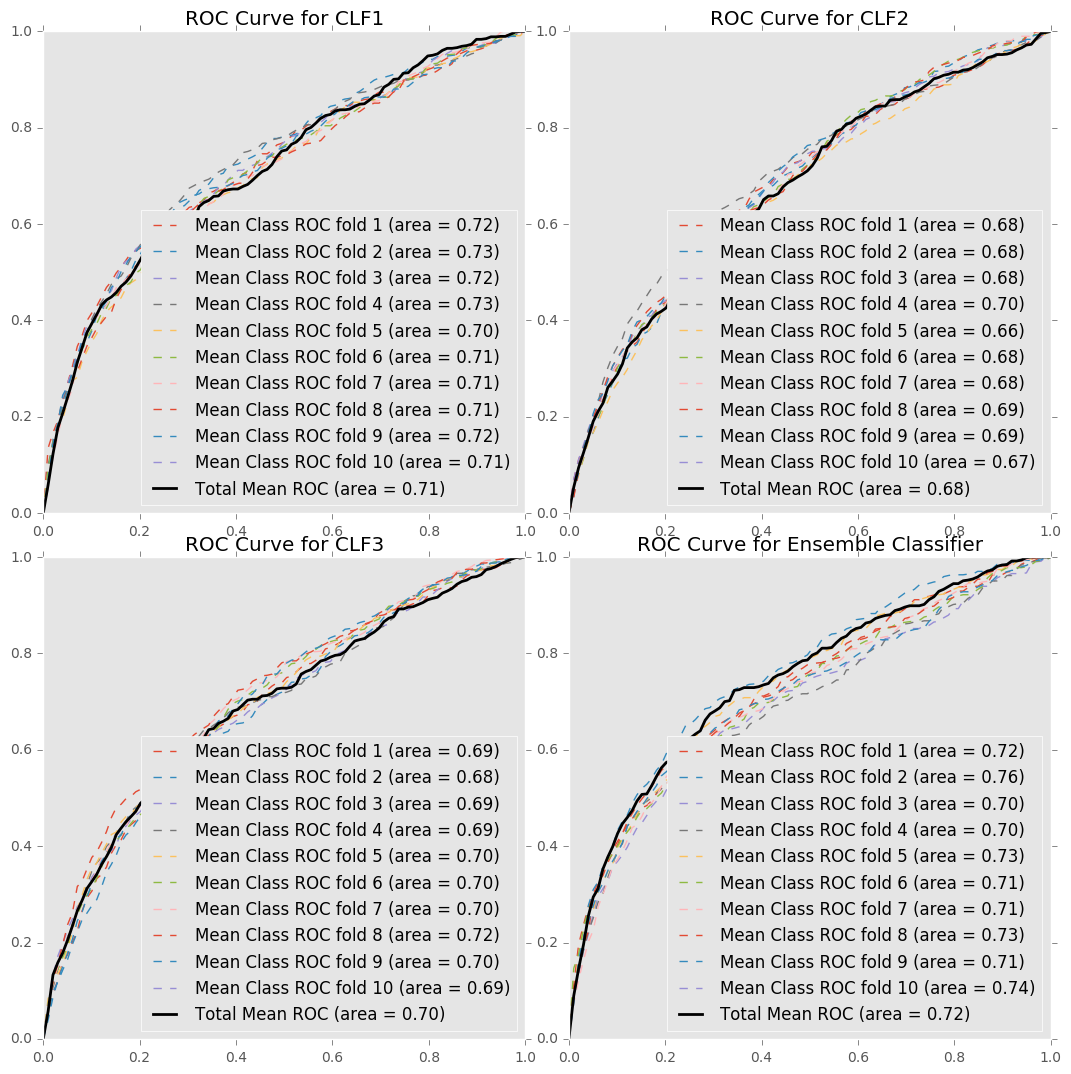

In [15]:
plt.figure(figsize=(13, 13))
gs = gridspec.GridSpec(4, 4)
ax1 = plt.subplot(gs[:2, :2])
ax1 = plt.title("ROC Curve for CLF1")
v_clf_1 = valuate_clf(clf=clf_1)
ax2 = plt.subplot(gs[:2,-2:])
ax2 = plt.title("ROC Curve for CLF2")
v_clf_2 = valuate_clf(clf=clf_2)
ax3 = plt.subplot(gs[-2:,:2])
ax3 = plt.title("ROC Curve for CLF3")
v_clf_3 = valuate_clf(clf=clf_3)
ax4 = plt.subplot(gs[-2:,-2:])
ax4 = plt.title("ROC Curve for Ensemble Classifier")
v_clf_e = valuate_clf(clf=eclf)

There are 4 ROC Curve plotted as above. The Ensemble Classifier has the largest total mean ROC area compared to the other. Therefore, it matches our expectation that the ensemble classifier will perform better than the individuals weak learners. However, the performance in Ensemble Classifier only have slight advantage compared to other individuals. Our guessing is that the MLP nuetral network is comparatively strong learner compared to Decision Trees or other classifier. Therefore, the ensemble might not have significant advantages if ensemble all MLP claasifiers.

Anyway, it is still some evidence that Ensemble Classifier does BETTER.

#### 3.3.2 Confusion Matrix

The on-line source helps us created the confusion matrix visualizaiton function. As there are 10-fold in the crsos validation, the mean count of each predicted class is used in the confusion matrix. 

In [16]:
#cited from sklearn confusion matrix visualization

import itertools
from sklearn.metrics import confusion_matrix

# create a function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 193.   73.    0.    0.]
 [ 116.  143.    0.    0.]
 [  98.   78.    0.    0.]
 [  34.   22.    0.    0.]]
Confusion matrix, without normalization
[[ 216.   29.   21.    0.]
 [  37.  178.   44.    1.]
 [  69.   78.   29.    0.]
 [  34.   16.    6.    0.]]
Confusion matrix, without normalization
[[ 146.   92.   29.    0.]
 [  55.  162.   42.    0.]
 [  68.   84.   24.    0.]
 [  24.   25.    7.    0.]]
Confusion matrix, without normalization
[[ 251.   15.    0.    0.]
 [  36.  223.    0.    0.]
 [  96.   80.    0.    0.]
 [  38.   18.    0.    0.]]


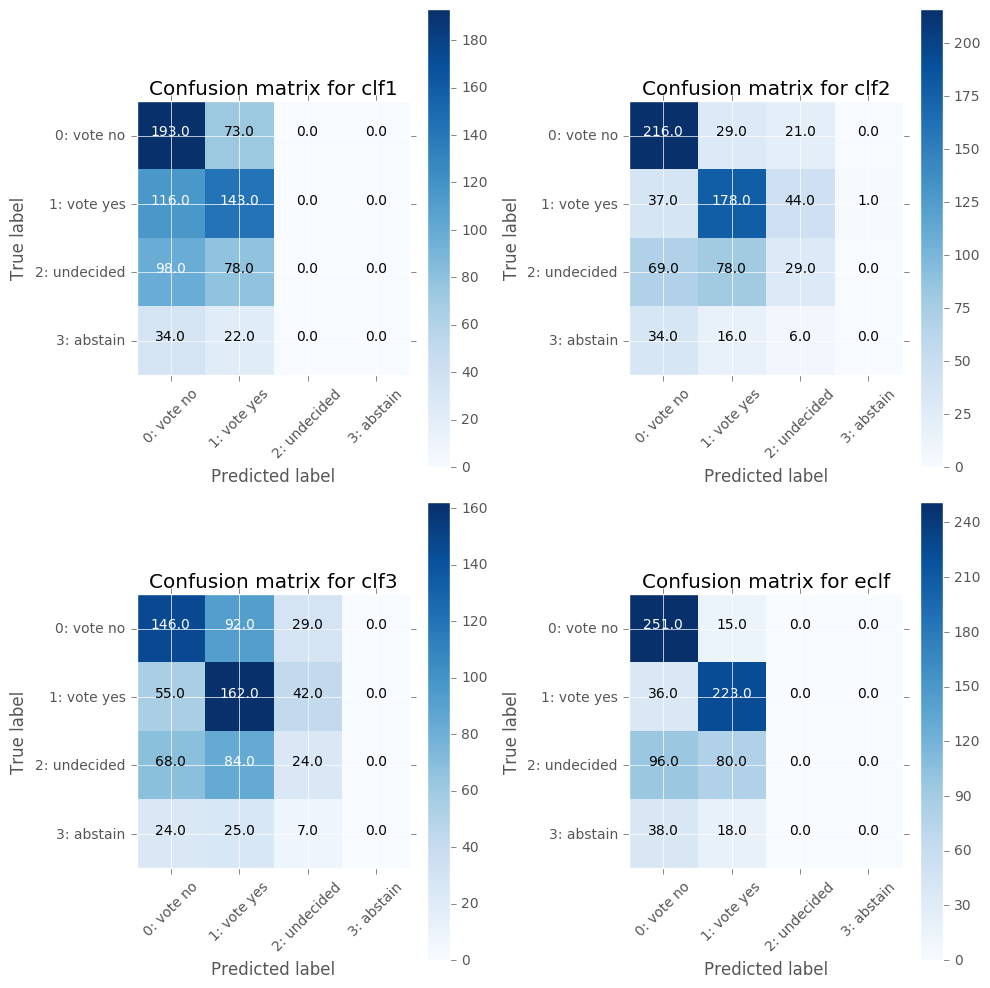

In [17]:
class_names = ['0: vote no', '1: vote yes', '2: undecided', '3: abstain']

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(4, 4)

ax1 = plt.subplot(gs[:2, :2])
plot_confusion_matrix(v_clf_1['mean_cfm'], classes=class_names,
                      title='Confusion matrix for clf1')

ax2 = plt.subplot(gs[:2,-2:])
plot_confusion_matrix(v_clf_2['mean_cfm'], classes=class_names,
                      title='Confusion matrix for clf2')

ax3 = plt.subplot(gs[-2:,:2])
plot_confusion_matrix(v_clf_3['mean_cfm'], classes=class_names,
                      title='Confusion matrix for clf3')

ax4 = plt.subplot(gs[-2:,-2:])
plot_confusion_matrix(v_clf_e['mean_cfm'], classes=class_names,
                      title='Confusion matrix for eclf')

plt.show()

From the 4 confusion matrix above, we can clearly see that the mean count of each true predicted class in the matrix 4 is larger than others. However, it is not a big advantage in the true predicted mean count compared to CLF2. As we stated before, Ensemble Classifer still has the better performance even though it is not a big advantage.

#### 3.3.3 Evaluation Scores -- F1

In [18]:
print('The first classifier: clf_1')
print('The micro-f1 scores for test sets after 10 times of splitting:')
for f1 in v_clf_1['f1 scores']:
    print('%.3f' % (f1))
print('\nCV f1: %.3f +/- %.3f' % (np.mean(v_clf_1['f1 scores']), np.std(v_clf_1['f1 scores'])))

print('------------------------------------')
print('The first classifier: clf_2')
print('The micro-f1 scores for test sets after 10 times of splitting:')
for f1 in v_clf_2['f1 scores']:
    print('%.3f' % (f1))
print('\nCV f1: %.3f +/- %.3f' % (np.mean(v_clf_2['f1 scores']), np.std(v_clf_2['f1 scores'])))

print('------------------------------------')
print('The first classifier: clf_3')
print('The micro-f1 scores for test sets after 10 times of splitting:')
for f1 in v_clf_3['f1 scores']:
    print('%.3f' % (f1))
print('\nCV f1: %.3f +/- %.3f' % (np.mean(v_clf_3['f1 scores']), np.std(v_clf_3['f1 scores'])))

print('------------------------------------')
print('The first classifier: eclf')
print('The micro-f1 scores for test sets after 10 times of splitting:')
for f1 in v_clf_e['f1 scores']:
    print('%.3f' % (f1))
print('\nCV f1: %.3f +/- %.3f' % (np.mean(v_clf_e['f1 scores']), np.std(v_clf_e['f1 scores'])))

The first classifier: clf_1
The micro-f1 scores for test sets after 10 times of splitting:
0.342
0.464
0.643
0.351
0.398
0.399
0.476
0.391
0.627
0.351

CV f1: 0.444 +/- 0.105
------------------------------------
The first classifier: clf_2
The micro-f1 scores for test sets after 10 times of splitting:
0.561
0.534
0.554
0.583
0.544
0.561
0.550
0.571
0.577
0.548

CV f1: 0.558 +/- 0.015
------------------------------------
The first classifier: clf_3
The micro-f1 scores for test sets after 10 times of splitting:
0.342
0.232
0.555
0.606
0.402
0.353
0.363
0.596
0.345
0.592

CV f1: 0.439 +/- 0.128
------------------------------------
The first classifier: eclf
The micro-f1 scores for test sets after 10 times of splitting:
0.631
0.620
0.634
0.638
0.629
0.626
0.613
0.635
0.604
0.638

CV f1: 0.627 +/- 0.011


From the 10 f1 socres in each classifier, we can see the Ensemble Classifier has the bigger f1 score in terms of the numbers. To have a better visualization to compre the f1 scores, a boxplot is being plotted.

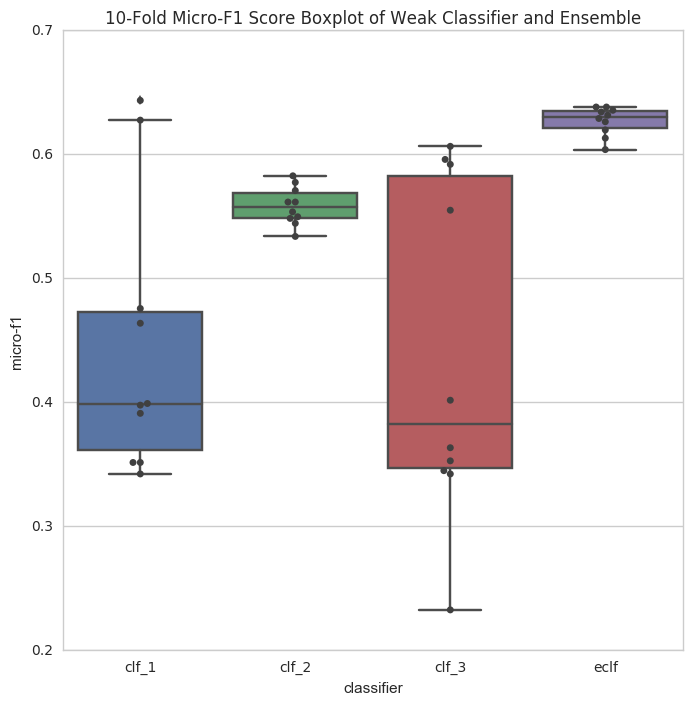

In [19]:
import seaborn as sns

df_f1 = pd.DataFrame()
df_f1['classifier'] = ['clf_1']*10 + ['clf_2']*10 + ['clf_3']*10 +['eclf']*10
df_f1['split_inter'] = list(range(1, 11))*4
df_f1['micro-f1'] = v_clf_1['f1 scores'] + v_clf_2['f1 scores'] + v_clf_3['f1 scores'] + v_clf_e['f1 scores']

fig = plt.figure(1, figsize=(8, 8))
sns.set_style("whitegrid")

ax = sns.boxplot(x="classifier", y="micro-f1", data=df_f1)
ax = sns.plt.title('10-Fold Micro-F1 Score Boxplot of Weak Classifier and Ensemble')
ax = sns.swarmplot(x="classifier", y="micro-f1", data=df_f1, color=".25")

From the boxplot, the Esemble Classifier definitely have the highest position compared to the others.

In addition, the CLF2 is also a nice learner due to its low standard deviation and compartively high position in boxplot. Here it explains why we do not have a huge advantage in Ensemble Classifier compared to individual classifers. If the CLF2 has similar weak performance as CLF1 and CLF3, we are able to see more advantage in Ensemble Classifier compared to the individuals.

___
<a id="EX"></a>
<a href="#top">Back to Top</a>
## 4.  Exceptional Work

In the class, the slide shows the way to get weight by using logistic, so here we want to compare the result by average weight and the result by logsitic.

In [20]:
from sklearn.linear_model import LogisticRegression

class elf_logistic(elf):
    
    def convertX(self, X):                             #convert train data set to probability matrix
        """Predict class labels"""
        result=[]
        for base in self.ests:
            result.append(base.predict_proba(X))
        
        result = np.array(result)
        bagging=result.shape[0]     
        sample=result.shape[1]
        label=result.shape[2]
        result = np.reshape(result, (bagging, sample*label))
        result = result.T
        return result
    
    def converty(self,y):                              #convert test data set to dummy colomn
        dum_y = pd.get_dummies(y)
        dum_y=np.array(dum_y)
        m=dum_y.shape[0]
        n=dum_y.shape[1]
        dum_y=np.reshape(dum_y,(m*n,1))
        return dum_y
    
    def log(self,X,y):                                 #build up logistic model
        X=self.convertX(X)
        y=self.converty(y)
        log = LogisticRegression(C=1000, dual=False, 
                                 fit_intercept=False,penalty='l2', 
                                 tol=0.1, solver="lbfgs")
        
        self.lfit = log.fit(X,y)
        
        return self
         
    def predict(self, X):                              #perdict label
        """Predict class labels"""

        self.X = self.convertX(X)
        y_pre = self.lfit.predict(self.X)
        m = y_pre.shape[0]
        y_pred = np.reshape(y_pre,(int(m/4),4))
        y_pred = np.argmax(y_pred, axis=1)
        return y_pred
    
    def predict_proba(self, X):                        #perdict probability
        """Predict class labels"""
        self.X = self.convertX(X)
        
        y_pre = self.lfit.predict(self.X)
        m=y_pre.shape[0]
        mean_proba = np.reshape(y_pre,(int(m/4),4))
        return mean_proba

In [22]:
# initiate the custom ensemble classifier
eclf_w = elf_logistic([clf_1,clf_2,clf_3])

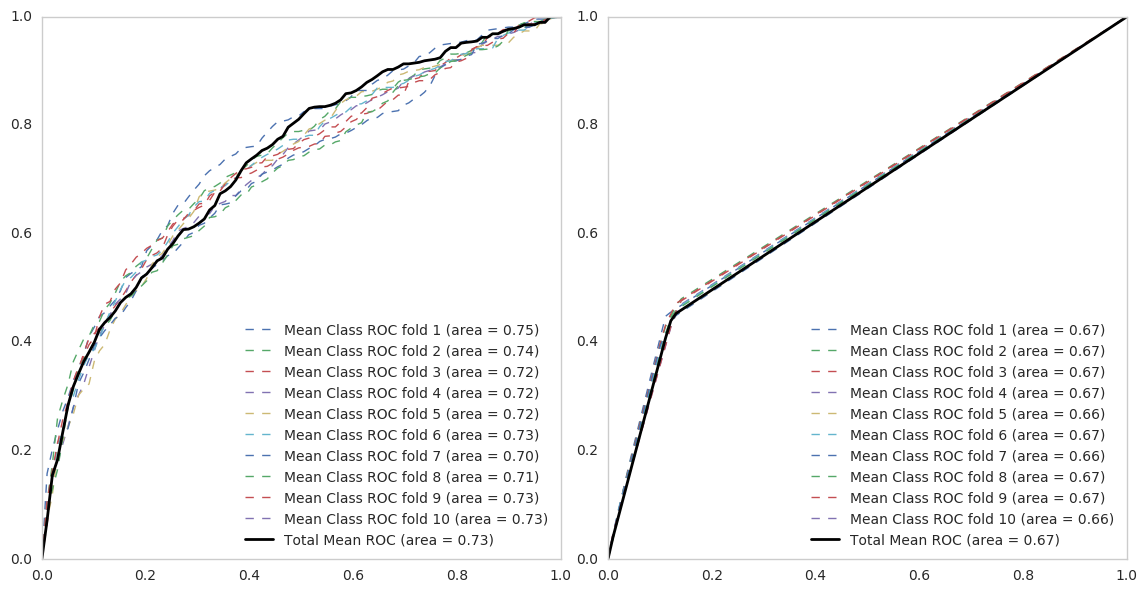

In [23]:
plt.figure(figsize=(14, 7))                    #plot
gs = gridspec.GridSpec(2, 4)
ax1 = plt.subplot(gs[:2,:2])
v_clf_e = valuate_clf(clf=eclf)
ax2 = plt.subplot(gs[:2,-2:])
v_clf_ew = valuate_clf(clf=eclf_w,method="log")

In [24]:
v_clf_ew["f1 scores"]

[0.62351387054161167,
 0.61294583883751652,
 0.61690885072655222,
 0.607661822985469,
 0.60369881109643331,
 0.60898282694848083,
 0.60237780713342137,
 0.61030383091149276,
 0.607661822985469,
 0.58916776750330246]

we can see that when the bagging 300 times(100 per different classifier), the behaviour of using logsitics weight is far below than the average weight. We are surprised about the results since the logistic weight is supposed to be better than average weight. So we wonder that maybe the bagging times is the key issues for liogistics weight here.

In [26]:
def valuate_clf2(clf=clf_1,method='avg'):
    
    f1_clf = []
    cfm_clf = np.zeros((4,4))

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    for i, (train_index, test_index) in enumerate(cv_outerloop.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        classes = np.unique(y_train)    
    
        clf.fit(X_train, y_train)
    
        if method=="log":
            clf.log(X_train, y_train)
            y_pred = clf.predict(X_test)
            probas = clf.predict_proba(X_test)
        else:
            y_pred = clf.predict(X_test)
            probas = clf.predict_proba(X_test)
            
            
        external_f1 = f1_score(y_test, y_pred, average='micro')
        f1_clf.append(external_f1)
        
        cnf_matrix = confusion_matrix(y_test, y_pred)
        cfm_clf += cnf_matrix
    
    return {'mean_cfm':np.round(cfm_clf/10), 'f1 scores':f1_clf}

In [27]:
f1_avglist=[]
for i in [10,50,100,400,700,1000]:
    xx = elf([clf_1,clf_2,clf_3],n_estimators=i)
    v_clf_xx = valuate_clf2(clf=xx,method="avg")
    f1_mean=np.mean(v_clf_xx["f1 scores"])
    f1_avglist.append(f1_mean)   

In [28]:
f1_loglist=[]
for i in [10,50,100,400,700,1000]:
    xx = elf_logistic([clf_1,clf_2,clf_3],n_estimators=i)
    v_clf_yy = valuate_clf2(clf=xx,method="log")
    f1_mean=np.mean(v_clf_yy["f1 scores"])
    f1_loglist.append(f1_mean)

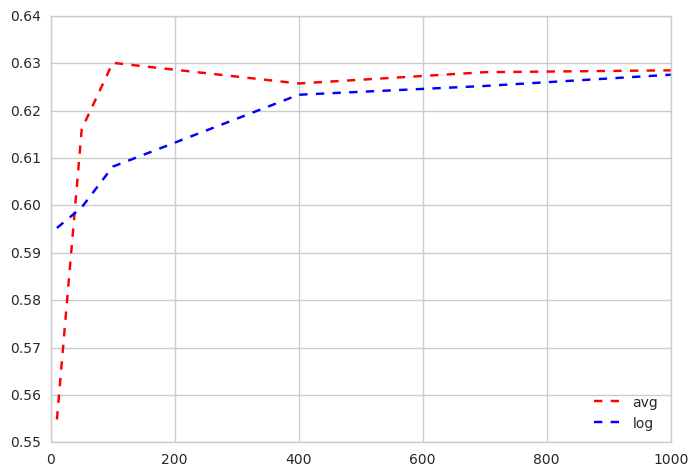

In [29]:
import matplotlib.pyplot as plt

# evenly sampled time at 200ms intervals
t = [10,50,100,400,700,1000]

# red dashes, blue squares and green triangles
a=plt.plot(t, f1_avglist, 'r--',label = 'avg')
b=plt.plot(t, f1_loglist , 'b--',label = 'log')
plt.legend(loc="lower right")

plt.show()

The plot shows that using average weight is around 0.62 no matter how large the bagging time is, so if bagging time is costly, we'd better use averge weight method. Logistic weight tends to behave better after the bagging times grow larger. This tells us if we want to get a good clssification behaviour using logistic method, we have to increase the bagging times.

After comparing those two methods, we still can't conclude which method is better since it is highly depends on the data set. So we should keep those two methods in the mind.

___
<a id="RE"></a>
<a href="#top">Back to Top</a>
## Reference

Scikit-Learn. Confution Matrix Visualization.
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py (Accessed 3/30/2017)

Vincentarelbundock. Rdatasets. Voting Intentions in the 1988 Chilean Plebiscite.  
    http://vincentarelbundock.github.io/Rdatasets/datasets.html (Accessed 2/27/2017)

Wikipedia. Data dredging.
    https://en.wikipedia.org/wiki/Data_dredging (Accessed 2/27/2017)
    
Wikipedia. Chilean Natioanl Plebiscite, 1998
    https://en.wikipedia.org/wiki/Chilean_national_plebiscite,_1988#Plebiscite (Accessed 3/24/2017)

Data Science Stack Exchange. Micro Average vs Macro average Performance in a Multiclass classification setting.
    http://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin/16001 (Accessed 3/23/2017)